In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import *
import pandas as pd

In [2]:
## Knapmeyer et al. seismic moment values
Mw = [1,2,3,4,5,6,7, 7.6]
M0 = [4e10, 1.3e13, 4e14, 1.3e16, 4e17, 1.3e19, 4e20, 3.2e21]
strongfew  = [38*60, 5.5*20*60, 1.9*24*60*60 , 17.1*24*60*60, 148*24*60*60, 3.6*365.25*24*60*60, 30.3*365.25*24*60*60, 115*365.25*24*60*60]
strongmany = [72, 10.5*60, 1.5*3600, 13.1*60*60]
medium = [48.5*60, 7*60*60, 2.5*24*3600, 21.8*24*3600, 189*24*3600, 4.5*365.25*24*3600]
weakmany = [2.5*3600, 21.9*3600, 7.9*24*3600, 68.5*24*3600]
weakfew = [3.9*24*3600, 33.5*24*3600, 290*24*3600, 6.7*365.25*24*3600, 50*365.25*24*3600, 516*365.25*24*3600, 4500*365.25*24*3600, 170000*365.25*24*3600]


knapmeyer_arr = np.zeros((len(M0), 7))
knapmeyer_arr[:,0] = Mw
knapmeyer_arr[:,1] = M0
knapmeyer_arr[0:len(strongfew),2] = strongfew
knapmeyer_arr[0:len(strongmany),3] = strongmany
knapmeyer_arr[0:len(medium),4] = medium
knapmeyer_arr[0:len(weakfew),5] = weakfew
knapmeyer_arr[0:len(weakmany),6] = weakmany

In [32]:
## Golombek sesimic moments
M0 = np.geomspace(10e10, 10e20, 11)
M0 = np.delete(M0, 1)

mb = np.array([1,2.2,2.8,3.4,4,4.6,5.2,5.8,6.4,7])
Gol_rec_rates = np.array([14*60, 3.7*3600, 15*3600, 2.5*24*3600, 9.8*24*3600, 1.3*30*24*3600, 5*30*24*3600, 1.7*365.25*24*3600, 6.7*365.25*24*3600, 27*365.25*24*3600])
golombek_arr = np.zeros((len(M0), 3))
golombek_arr[:,0] = mb
golombek_arr[:,1] = M0
golombek_arr[:,2] = Gol_rec_rates

## 1. Lithopheric cooling

$T(z) = T_{s} + (T_{m} - T_{s})erf(\frac{z}{(2kt)^.5})$

In [3]:
Ts = 473 
Tm = 1300
Tz = 600
kappa = 1*1e-6/3.17098e-8     ## in m2/yr

In [4]:
def halfspacecooling(tzlist):
    t = tzlist[0]
    z = tzlist[1]
    
    Ts = 473
    Tm = 1300
    kappa = 1*1e-6/3.17098e-8  
    
    T = np.zeros_like(t)
    T = Ts + (Tm-Ts)*erf(z/np.sqrt(2*kappa*t))
    
    return T

depth = np.linspace(0, 200e3, 1000)
age = np.linspace(0, 4.5e9, 10000)

t, d = np.meshgrid(age, depth)
T = halfspacecooling([t, d])

/tmp/ipykernel_19794/1024951780.py:10: RuntimeWarning: divide by zero encountered in divide
  T = Ts + (Tm-Ts)*erf(z/np.sqrt(2*kappa*t))
/tmp/ipykernel_19794/1024951780.py:10: RuntimeWarning: invalid value encountered in divide
  T = Ts + (Tm-Ts)*erf(z/np.sqrt(2*kappa*t))


In [5]:
## cooling rate
Tdot = np.gradient(T, axis = 1, edge_order = 1)
print(Tdot)

[[            nan             nan  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.91951092e+02 -4.01105424e+02 -7.40353125e+00 ... -1.75405927e-05
  -1.75379612e-05 -1.75366455e-05]
 [-7.57001000e+02 -3.88728335e+02 -1.47671766e+01 ... -3.50811706e-05
  -3.50759075e-05 -3.50732763e-05]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.51972823e-02
  -1.51952156e-02 -1.51941824e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.52082393e-02
  -1.52061716e-02 -1.52051379e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.52191846e-02
  -1.52171159e-02 -1.52160817e-02]]


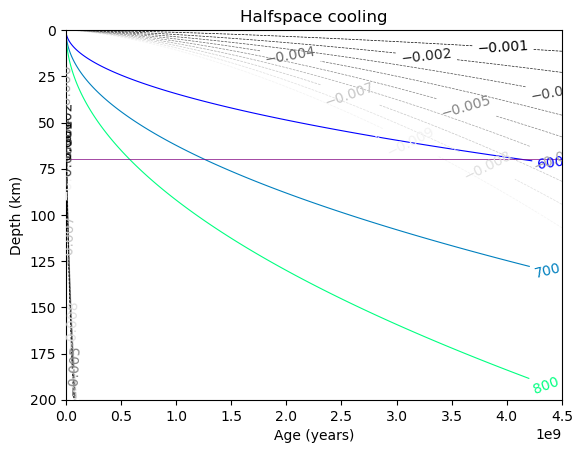

In [6]:
cs = plt.contour(t, d/1e3, T, levels = [600, 700, 800], cmap = "winter", linewidths=0.8)
cs1 = plt.contour(t, d/1e3, Tdot, levels=np.linspace(-0.01, -0.001, 10), cmap="Greys", linewidths = 0.5, linestyles = '--')
plt.clabel(cs)
plt.clabel(cs1)
plt.title('Halfspace cooling')
plt.gca().invert_yaxis()
# cbar = plt.colorbar()
# cbar.set_label("Temperature (deg C)")
plt.axhline(70, age[0], age[-1], color='purple', linewidth=0.5)
plt.xlabel("Age (years)")
plt.ylabel("Depth (km)")
plt.show()

Note: Cooling rate calculated for time intrval of 0.45 Myr.

### 1.1 Strain rate due to lithospheric contraction

In [7]:
def moment2magnitude(m0):
    mw = 2/3 * (np.log10(m0) - 9.1)
    return mw

def moment2surmagnitude(m0):
    ms = np.log10(m0*.001)-19.46
    return ms

def magnitude2moment(mw):
    m0 = np.power(10, (3/2 *mw + 9.1))
    return m0

def cumulative_moment(strain_rate, seis_volume, seis_efficiency=1, time = 365.25*24*60*60, shear_mod = 7e10):
    Mcum = seis_efficiency * strain_rate * seis_volume * shear_mod * time
    return Mcum

def adot_parameter(strainrate, seisvolume, m0_max=10e20, beta = 0.67, shearmod = 7e10):
    adot = (1-beta)/beta * np.power(m0_max, beta-1) * strainrate * shearmod * seisvolume 
    return adot

def recurrence_rate(m0_min, m0_max, adot, beta=0.67):
    rec_rate = adot * (np.power(m0_min, -beta) - np.power(m0_max, -beta))
    return rec_rate

In [8]:
## strain rate
Ls = 70               ## in km
Rp = 6051.8            ## in km
alpha = 3e-5          ## volumetric thermal expansion coefficient in /K
V = (4/3) * np.pi * Rp**3 - (Rp-Ls)**3
cooling_rate = 1e-9 
strainrate_lith =  ((alpha* cooling_rate * V) / (4*np.pi*Ls*(Rp - Ls/2)**2))/(365.25*24*60*60)
print("the strain rate per second is = ", '{:.2e}'.format(strainrate_lith))


## cumulative moment
Mcum = cumulative_moment(strainrate_lith, V*1e9)
print("the cumulative moment is = ", '{:.2e}'.format(Mcum))

the strain rate per second is =  2.13e-20
the cumulative moment is =  3.37e+19


In [9]:
## recurrence rate  - Phillips 1991 values  
beta = 0.67          ##(Phillips 1991)
m0_max = 10e20       ## in Nm
m0_min = 10e14
adot = adot_parameter(strainrate_lith, V*1e9, m0_max)
m0_range = np.geomspace(m0_min, m0_max, num=7)
print(m0_range)

range_l = m0_range[:-1].reshape((1,-1))
range_r = m0_range[1:].reshape((1,-1))

m0_pairs = np.concatenate((range_l, range_r), axis = 0).T
rec_rates = []

for pair in m0_pairs:
    rr = recurrence_rate(pair[0], pair[1], adot, beta=0.67)
    rec_rates.append(rr)
    
events_arr = np.zeros((len(rec_rates), 3))
events_arr[:,0] = np.array(rec_rates)
events_arr[:,1] = (365.25*24*60*60) * events_arr[:,0]
events_arr[:,2] = events_arr[:,1]/ 4
print(events_arr)
print(m0_range)

[1.e+15 1.e+16 1.e+17 1.e+18 1.e+19 1.e+20 1.e+21]
[[4.32417265e-06 1.36460511e+02 3.41151277e+01]
 [9.24491720e-07 2.91747399e+01 7.29368498e+00]
 [1.97652825e-07 6.23744879e+00 1.55936220e+00]
 [4.22574247e-08 1.33354290e+00 3.33385726e-01]
 [9.03447719e-09 2.85106417e-01 7.12766044e-02]
 [1.93153697e-09 6.09546712e-02 1.52386678e-02]]
[1.e+15 1.e+16 1.e+17 1.e+18 1.e+19 1.e+20 1.e+21]


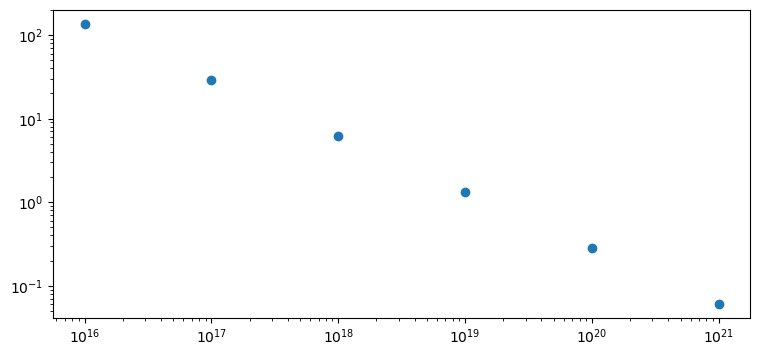

In [10]:
fig, ax = plt.subplots(1,1, figsize=(9,4))
ax.scatter(m0_range[1:],events_arr[:,1])
# ax.set_xlim(m0_range[0], m0_range[-1])
ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10) 
plt.show()

In [11]:
## recurrence rates - magnitudes

magnitudes = np.arange(1,8,1)
moments = magnitude2moment(magnitudes)
print(moments)

range_l = moments[:-1].reshape((1,-1))
range_r = moments[1:].reshape((1,-1))

mom_pairs = np.concatenate((range_l, range_r), axis = 0).T
rec_rates = []

for pair in mom_pairs:
    rr = recurrence_rate(pair[0], pair[1], adot, beta=0.67)
    rec_rates.append(rr)
    
events_arr = np.zeros((len(rec_rates), 3))
events_arr[:,0] = np.array(rec_rates)
events_arr[:,1] = (365.25*24*60*60) * events_arr[:,0]
events_arr[:,2] = events_arr[:,1]/ 4
print(magnitudes)
print(events_arr)

[3.98107171e+10 1.25892541e+12 3.98107171e+13 1.25892541e+15
 3.98107171e+16 1.25892541e+18 3.98107171e+19]
[1 2 3 4 5 6 7]
[[4.39706029e-03 1.38760670e+05 3.46901675e+04]
 [4.34672756e-04 1.37172290e+04 3.42930724e+03]
 [4.29697098e-05 1.35602091e+03 3.39005228e+02]
 [4.24778396e-06 1.34049867e+02 3.35124668e+01]
 [4.19915998e-07 1.32515411e+01 3.31288527e+00]
 [4.15109259e-08 1.30998520e+00 3.27496299e-01]]


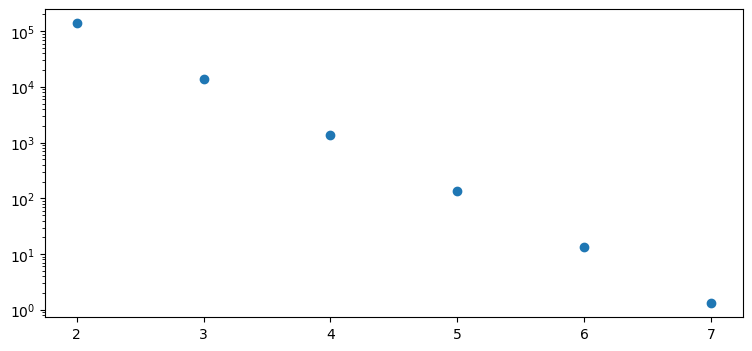

In [12]:
fig, ax = plt.subplots(1,1, figsize=(9,4))
ax.scatter(magnitudes[1:],events_arr[:,1])
ax.set_yscale('log') 
plt.show()

In [13]:
## comparison with Knapmeyer plots
## recurrence rate  - Phillips 1991 values  
beta = 0.67          ##(Phillips 1991)
m0_max = 10e20      ## in Nm
m0_min = 10e10
adot = adot_parameter(strainrate_lith, V*1e9, m0_max)
m0_range = np.geomspace(m0_min, m0_max, num=11)
print(m0_range)
m0_min_knapmeyer = 3.98e10 

rec_rates = []
for mom in m0_range:
    rr = recurrence_rate(mom, m0_max, adot, beta=0.67)
    rec_rates.append(rr)
    
events_arr = np.zeros((len(rec_rates), 3))
events_arr[:,0] = np.array(rec_rates)
events_arr[:,1] = (365.25*24*60*60) * events_arr[:,0]
events_arr[:,2] = events_arr[:,1]/ 4
print(events_arr)

[1.e+11 1.e+12 1.e+13 1.e+14 1.e+15 1.e+16 1.e+17 1.e+18 1.e+19 1.e+20
 1.e+21]
[[2.63249652e-03 8.30752722e+04 2.07688180e+04]
 [5.62817363e-04 1.77611652e+04 4.44029130e+03]
 [1.20327806e-04 3.79725676e+03 9.49314189e+02]
 [2.57252157e-05 8.11826067e+02 2.02956517e+02]
 [5.49954064e-06 1.73552304e+02 4.33880759e+01]
 [1.17536798e-06 3.70917927e+01 9.27294817e+00]
 [2.50876264e-07 7.91705278e+00 1.97926320e+00]
 [5.32234388e-08 1.67960399e+00 4.19900998e-01]
 [1.09660142e-08 3.46061089e-01 8.65152722e-02]
 [1.93153697e-09 6.09546712e-02 1.52386678e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


/tmp/ipykernel_19794/2478655512.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,3], "o-" , label = "mars_strongmany", c = "#dfc0eb")
/tmp/ipykernel_19794/2478655512.py:5: RuntimeWarning: divide by zero encountered in divide
  ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,4], "o-" , label = "mars_medium", c = "#d5a6e6")
/tmp/ipykernel_19794/2478655512.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,6], "o-" , label = "mars_weakfew", c = "#c377e0")


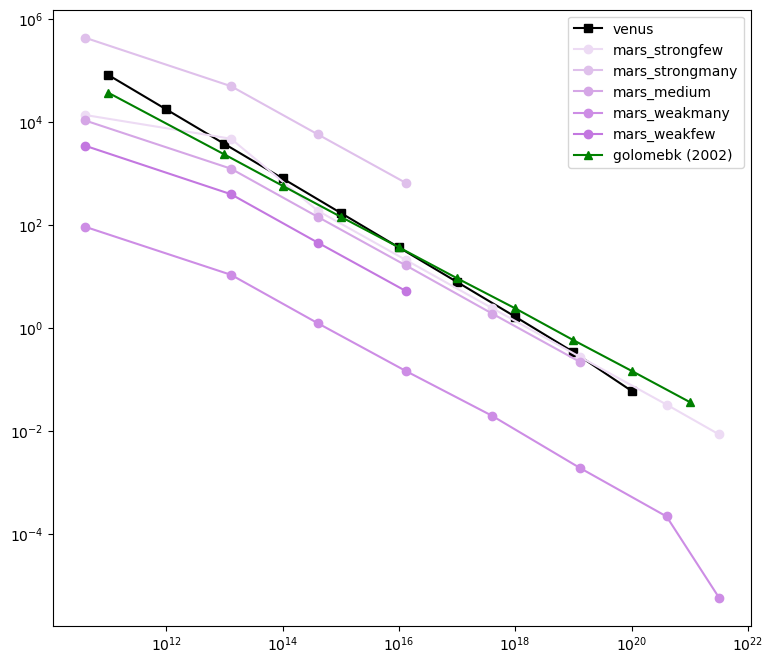

In [38]:
fig, ax = plt.subplots(1,1, figsize=(9,8))
ax.plot(m0_range[:-1],events_arr[:-1,1], "s-", label = "venus", c='k')
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,2], "o-" , label = "mars_strongfew", c = "#eddbf4",)
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,3], "o-" , label = "mars_strongmany", c = "#dfc0eb")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,4], "o-" , label = "mars_medium", c = "#d5a6e6")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,5], "o-" , label = "mars_weakmany", c = "#cd8de5")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,6], "o-" , label = "mars_weakfew", c = "#c377e0")
ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,2], "^-" , label = "golomebk (2002)", c= "green")
# ax.set_xlim(m0_range[0], m0_range[-1])
ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10)
ax.legend()
plt.show()